# Level Set to Signed Distance Function Interpolation

#### Steve Kelly, 2020-02-07

The objective is to evaluate a method for Level Set to Signed Distance Functions using the Intepolations.jl package.
This serves several purposes (non-exhaustive).
1. For complex models a true sampling of the SDF may be expensive
2. Topology Optimization
3. Some operations cannot be performed on pure-functions (convex hulls)
4. The construction of a level set from a function in embarrassingly parallel, but the conditions in which we may need to sample the SDF may not be.
5. Some data only comes in Level set form (CT Scans, Medical).


In [5]:
using Interpolations
using BenchmarkTools

In [6]:
circle(x,y,r) = sqrt(sum((x,y).^2)) - r;

In [10]:
n = 2000; x = LinRange(-1,1,n); y = x; @show length(x);

length(x) = 2000


In [12]:
@benchmark ls = [circle(x[i], y[j], 0.5) for i = 1:n, j = 1:n]

BenchmarkTools.Trial: 
  memory estimate:  304.50 MiB
  allocs estimate:  17956010
  --------------
  minimum time:     323.216 ms (2.63% GC)
  median time:      362.615 ms (4.37% GC)
  mean time:        402.255 ms (12.40% GC)
  maximum time:     494.524 ms (27.36% GC)
  --------------
  samples:          13
  evals/sample:     1

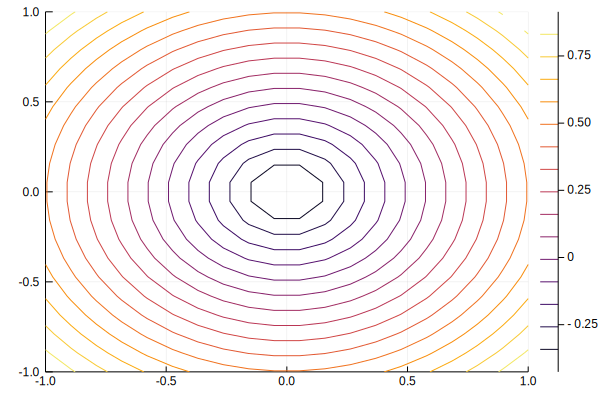

In [127]:
using Plots
contour(x,y,ls)

# Linear Cell

In [128]:
itp_lin = interpolate((x,y), ls, Gridded(Linear()));

In [129]:
i1, t1 = itp_lin(0,0), circle(0,0,0.5);
@show i1 - t1;
i2, t2 = itp_lin(0.5,0), circle(0.5,0,0.5);
@show i2 - t2;

i1 - t1 = 0.07443229275647872
i2 - t2 = 0.0027831109420988175


# Constant Cell

In [130]:
itp_con = interpolate((x,y), ls, Gridded(Constant()));

In [131]:
i1, t1 = itp_con(0,0), circle(0,0,0.5);
@show i1 - t1;
i2, t2 = itp_con(0.5,0), circle(0.5,0,0.5);
@show i2 - t2;

i1 - t1 = 0.07443229275647861
i2 - t2 = -0.023400782203293946


# Comparison

In [132]:
using StatsBase

In [133]:
n_samples = 100; sample_pts = [(rand(),rand()) for i in 1:n_samples];

In [134]:
sample_itp_con = map(x -> itp_con(x...), sample_pts);
sample_itp_lin = map(x -> itp_lin(x...), sample_pts);
sample_true = map(x -> circle(x..., 0.5), sample_pts);
error_itp_con = sample_true .- sample_itp_con;
error_itp_lin = sample_true .- sample_itp_lin;

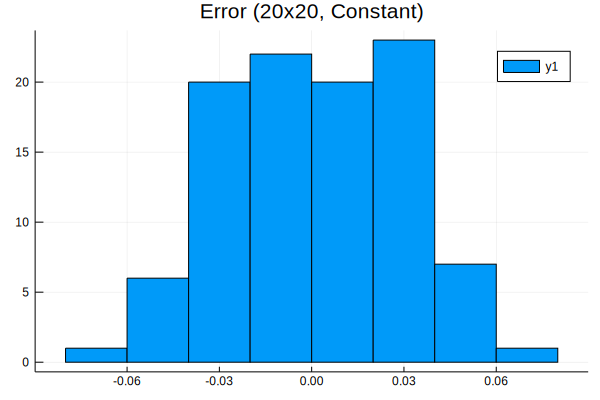

In [135]:
hist_con1 = histogram(error_itp_con, title="Error (20x20, Constant)")

In [136]:
describe(error_itp_con)

Summary Stats:
Length:         100
Missing Count:  0
Mean:           0.000358
Minimum:        -0.060059
1st Quartile:   -0.023657
Median:         0.001524
3rd Quartile:   0.023628
Maximum:        0.069072
Type:           Float64


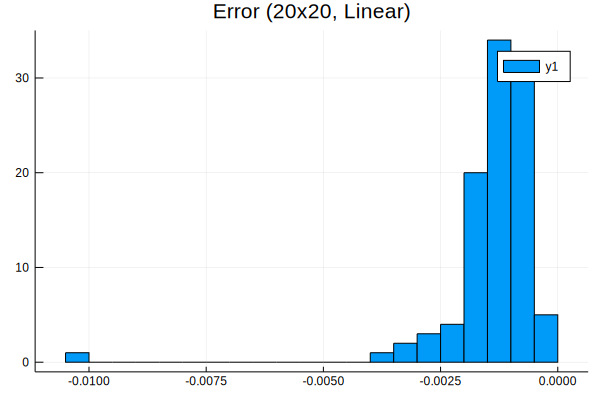

In [137]:
hist_lin1 = histogram(error_itp_lin, title="Error (20x20, Linear)")

In [138]:
describe(error_itp_lin)

Summary Stats:
Length:         100
Missing Count:  0
Mean:           -0.001391
Minimum:        -0.010341
1st Quartile:   -0.001571
Median:         -0.001262
3rd Quartile:   -0.000834
Maximum:        -0.000162
Type:           Float64


In [139]:
# Performance
using BenchmarkTools
@benchmark map(x -> itp_con(x...), $sample_pts)

BenchmarkTools.Trial: 
  memory estimate:  5.58 KiB
  allocs estimate:  302
  --------------
  minimum time:     12.590 μs (0.00% GC)
  median time:      14.770 μs (0.00% GC)
  mean time:        15.038 μs (0.00% GC)
  maximum time:     32.301 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [140]:
@benchmark map(x -> itp_lin(x...), $sample_pts)

BenchmarkTools.Trial: 
  memory estimate:  5.58 KiB
  allocs estimate:  302
  --------------
  minimum time:     10.350 μs (0.00% GC)
  median time:      12.470 μs (0.00% GC)
  mean time:        12.675 μs (0.00% GC)
  maximum time:     26.281 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [141]:
@benchmark map(x -> circle(x..., 0.5), $sample_pts)

BenchmarkTools.Trial: 
  memory estimate:  912 bytes
  allocs estimate:  2
  --------------
  minimum time:     153.951 ns (0.00% GC)
  median time:      183.456 ns (0.00% GC)
  mean time:        312.762 ns (17.57% GC)
  maximum time:     6.060 μs (94.38% GC)
  --------------
  samples:          10000
  evals/sample:     818

# Larger Grid Size

In [142]:
n = 500; x = collect(LinRange(-1,1,n)); y = x; @show length(x);

length(x) = 500


In [143]:
ls = [circle(x[i], y[j], 0.5) for i = 1:n, j = 1:n]

500×500 Array{Float64,2}:
 0.914214  0.911382  0.908557  0.905737  …  0.908557  0.911382  0.914214
 0.911382  0.908545  0.905714  0.902889     0.905714  0.908545  0.911382
 0.908557  0.905714  0.902877  0.900046     0.902877  0.905714  0.908557
 0.905737  0.902889  0.900046  0.897209     0.900046  0.902889  0.905737
 0.902923  0.900069  0.89722   0.894378     0.89722   0.900069  0.902923
 0.900115  0.897255  0.894401  0.891552  …  0.894401  0.897255  0.900115
 0.897312  0.894447  0.891587  0.888733     0.891587  0.894447  0.897312
 0.894516  0.891645  0.888779  0.885919     0.888779  0.891645  0.894516
 0.891725  0.888848  0.885977  0.883111     0.885977  0.888848  0.891725
 0.888941  0.886058  0.883181  0.880309     0.883181  0.886058  0.888941
 0.886162  0.883274  0.880391  0.877513  …  0.880391  0.883274  0.886162
 0.88339   0.880495  0.877606  0.874723     0.877606  0.880495  0.88339 
 0.880623  0.877723  0.874828  0.871939     0.874828  0.877723  0.880623
 ⋮                       

In [144]:
itp_lin_500 = interpolate((x,y), ls, Gridded(Linear()));

In [145]:
# Same sample points
sample_itp_lin500 = map(x -> itp_lin_500(x...), sample_pts);
error_itp_lin500 = sample_true .- sample_itp_lin500;

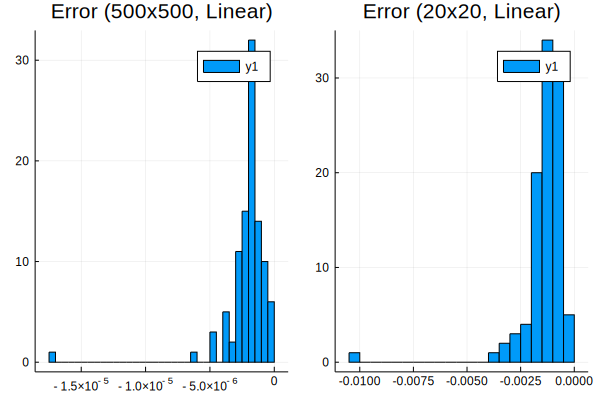

In [146]:
hist_lin2 = histogram(error_itp_lin500, title="Error (500x500, Linear)")
plot(hist_lin2, hist_lin1)

In [147]:
describe(error_itp_lin500)

Summary Stats:
Length:         100
Missing Count:  0
Mean:           -0.000002
Minimum:        -0.000017
1st Quartile:   -0.000002
Median:         -0.000002
3rd Quartile:   -0.000001
Maximum:        -0.000000
Type:           Float64


In [148]:
describe(error_itp_lin)

Summary Stats:
Length:         100
Missing Count:  0
Mean:           -0.001391
Minimum:        -0.010341
1st Quartile:   -0.001571
Median:         -0.001262
3rd Quartile:   -0.000834
Maximum:        -0.000162
Type:           Float64


In [149]:
@benchmark map(x -> itp_lin_500(x...), $sample_pts)

BenchmarkTools.Trial: 
  memory estimate:  5.58 KiB
  allocs estimate:  302
  --------------
  minimum time:     14.270 μs (0.00% GC)
  median time:      17.360 μs (0.00% GC)
  mean time:        17.971 μs (0.00% GC)
  maximum time:     73.542 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [150]:
@benchmark map(x -> itp_lin(x...), $sample_pts)

BenchmarkTools.Trial: 
  memory estimate:  5.58 KiB
  allocs estimate:  302
  --------------
  minimum time:     10.450 μs (0.00% GC)
  median time:      12.790 μs (0.00% GC)
  mean time:        13.236 μs (0.00% GC)
  maximum time:     51.791 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

Observations: The runtime scales minimally with the size of the level set

# 3D Analysis

In [151]:
n = 200; x = collect(LinRange(-1,1,n)); y = x; z = x; @show length(x);

length(x) = 200


In [152]:
sphere(x,y,z,r) = sqrt(sum((x,y,z).^2)) - r;

In [153]:
@time ls_sphere = [sphere(x[i], y[j], z[k], 0.5) for i = 1:n, j = 1:n, k = 1:n];

  0.964800 seconds (32.13 M allocations: 555.381 MiB, 4.91% gc time)


In [154]:
size(ls_sphere)

(200, 200, 200)

In [155]:
itp_sphere = interpolate((x,y,z), ls_sphere, Gridded(Linear())); # generate interpolation

In [156]:
n_samples = 100; sample_pts = [(rand(),rand(), rand()) for i in 1:n_samples];

In [157]:
sample_itp_sphere = map(x -> itp_sphere(x...), sample_pts);
sample_true = map(x -> sphere(x..., 0.5), sample_pts);
error_sphere = sample_itp_sphere .- sample_true;
describe(error_sphere)

Summary Stats:
Length:         100
Missing Count:  0
Mean:           0.000020
Minimum:        0.000004
1st Quartile:   0.000013
Median:         0.000018
3rd Quartile:   0.000025
Maximum:        0.000069
Type:           Float64


In [158]:
@benchmark map(x -> itp_sphere(x...), $sample_pts)

BenchmarkTools.Trial: 
  memory estimate:  7.14 KiB
  allocs estimate:  402
  --------------
  minimum time:     16.940 μs (0.00% GC)
  median time:      20.281 μs (0.00% GC)
  mean time:        21.242 μs (2.15% GC)
  maximum time:     4.604 ms (99.08% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [159]:
@benchmark map(x -> sphere(x..., 0.5), $sample_pts)

BenchmarkTools.Trial: 
  memory estimate:  912 bytes
  allocs estimate:  2
  --------------
  minimum time:     172.920 ns (0.00% GC)
  median time:      212.887 ns (0.00% GC)
  mean time:        350.998 ns (16.21% GC)
  maximum time:     6.855 μs (94.25% GC)
  --------------
  samples:          10000
  evals/sample:     723

Observation: with 250,000 points (2D) we had a median runtime of ~15 micro seconds and with 8,000,000 points (3D) we had a median runtime of ~20 micro seconds, so scaling is quite good. Similarly for the SDF of the circle the median runtime was ~250 nano seconds, and the sphere was ~590 nanoseconds. 

# Conclusion

The Interpolations.jl package provides a convenient way to convert a Level Set to an interpolation of a Signed Distance Function. This will be highly useful in DistMesh, and should provide an immediate path to supporting Level Set and Medical Data. There is a slight overhead compared to a direct sampling of the function, but for complex geometries this is likely to balance out. A good additional test case for this would be something involving trignometric functions.

